# Fake news prediction model


#### **NOTE**: Due to restrictions on GitHub (even with Large File Storage) we decided to upload our program set to train on a 10,000 row snippet of the full dataset. The training results from both the simple and advanced model can found in the pdf regarding this assignment. We decided to go with this approach to ensure reproduceability, but it can all be changed by switching out `"fake_news_dataset/10,000_data_cleaned_fr.csv"` with the `"995,000_rows.csv"` (of course with your own relative path as well).

## Dependencies

In [122]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Data processing

### Loading the cleaned data

In [123]:
chunk_size = 1000
rows = 868346
chunks = []

# * Load csv file with tqdm for tracking progress
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("fake_news_dataset/10,000_data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)
df = df.dropna(subset=['content', 'type'])

Loading csv file:   1%|          | 9339/868346 [00:00<00:24, 34650.24it/s]


### Distribution

In [124]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 8891
Fake article amount: 0
Reliable article amount: 0
Reliable percentage: 0.00%


# Simple model

We will try to add the cleaned BBC dataset to our current one, and see how the model performs.

In [125]:
df2 = pd.read_csv('bbc_dataset/bbc_cleaned_fr.csv')

# Concatenate vertically (stacking rows)
merged_df = pd.concat([df, df2], ignore_index=True)

merged_df.to_csv('bbc_dataset/merged_data.csv', index=False)

### Splitting

In [126]:
merged_df['type'] = merged_df['type'].astype(str)

X = merged_df['content']
y = merged_df['type'] 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

### Vectorization and training

In [127]:

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)
print(class_counts / len(y_train) * 100)

# Create feature extraction pipeline with n-grams
feature_extraction = Pipeline([
    ('vect', CountVectorizer(
        max_features=10000,             # Limit to top 10,000 features
    )),
    #('tfidf', TfidfTransformer()),
])

# Apply feature extraction to training data
X_train_features = feature_extraction.fit_transform(X_train)
print(f"\nFeature matrix shape: {X_train_features.shape}")

# Find the minimum number of samples in any class
min_class_count = min(class_counts)
print(f"Minimum class count: {min_class_count}")


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

# Show class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

# Train the logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)


Class distribution in training set:
type
1.0    5270
0.0    2971
Name: count, dtype: int64
type
1.0    63.94855
0.0    36.05145
Name: count, dtype: float64

Feature matrix shape: (8241, 10000)
Minimum class count: 2971

Class distribution after resampling:
Class 0.0: 5270 samples (50.00%)
Class 1.0: 5270 samples (50.00%)


LogisticRegression(max_iter=1000)

### Evaluation

Testing the model on the validation set

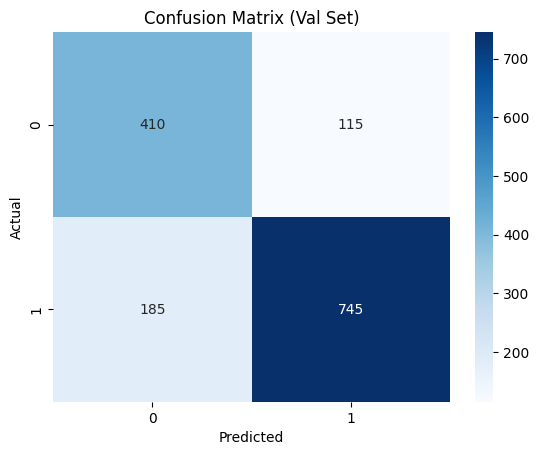


Classification Report for Val Set:
               precision    recall  f1-score   support

         0.0       0.69      0.78      0.73       525
         1.0       0.87      0.80      0.83       930

    accuracy                           0.79      1455
   macro avg       0.78      0.79      0.78      1455
weighted avg       0.80      0.79      0.80      1455



In [128]:
X_val_features = feature_extraction.transform(X_val)
y_pred = clf.predict(X_val_features)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Val Set)')
plt.show()

print("\nClassification Report for Val Set:\n", classification_report(y_val, y_pred))

## Applying the model to the liars dataset


Validation Set Accuracy: 0.5472557223726311

Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.56      0.91      0.69      4488
           1       0.47      0.10      0.17      3638

    accuracy                           0.55      8126
   macro avg       0.51      0.51      0.43      8126
weighted avg       0.52      0.55      0.46      8126



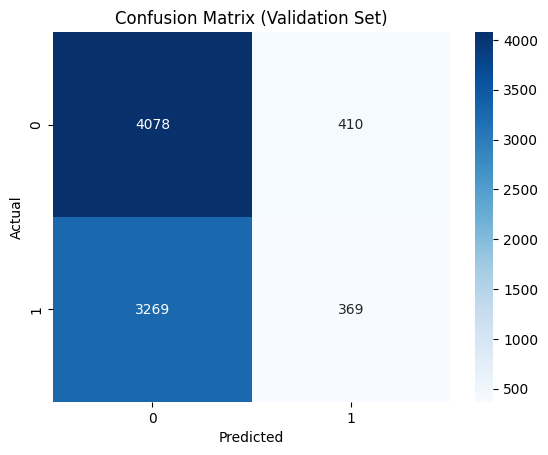

In [129]:
# Load dataset
liar_data = pd.read_csv("liar_dataset/liar_fr.csv")

# Define features and target
X_liar_val = liar_data['content']
y_liar_val = liar_data['type'].astype(int)

# Transform validation data using a pre-fitted vectorizer
liar_features = feature_extraction.transform(X_liar_val)  # No fit, just transform

# Predict using a pre-trained classifier
y_liar_val_pred = clf.predict(liar_features)

y_liar_val_pred = y_liar_val_pred.astype(float).astype(int)

# Evaluation metrics
print("\nValidation Set Accuracy:", accuracy_score(y_liar_val, y_liar_val_pred))
print("\nClassification Report for Validation Set:\n", classification_report(y_liar_val, y_liar_val_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_liar_val, y_liar_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

Retraining the model with metadata 'domain_names' 

Available columns: ['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary', 'source', 'processed_category']
Features being used for training:
- text: content

Feature matrix shape after preprocessing: (7557, 10000)

Class distribution in training set:
type
1.0    4586
0.0    2971
Name: count, dtype: int64

Applying SMOTE...

Training model...

Test set evaluation:
Accuracy: 0.8193

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       525
         1.0       0.88      0.82      0.85       809

    accuracy                           0.82      1334
   macro avg       0.81      0.82      0.81      1334
weighted avg       0.82      0.82      0.82      1334


Feature importance analysis:

Top 20 most important words:
1. sourc: -5.5981
2. blockchain: -5.1349
3. getti: -5.0006
4. cent: -4.411

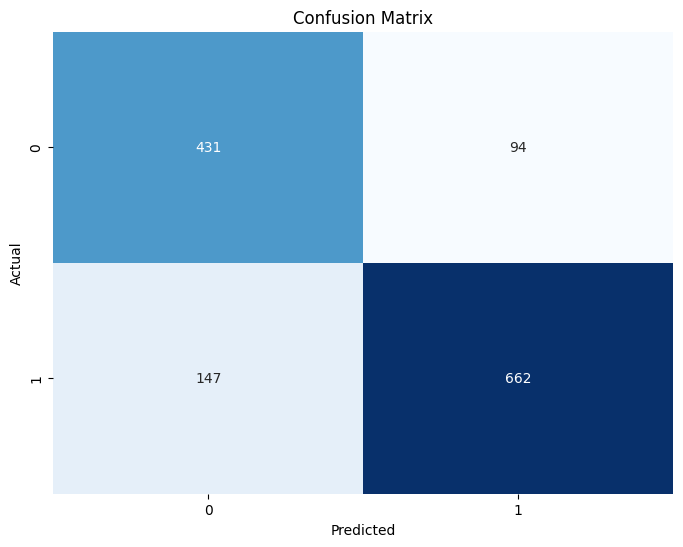

In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

text_column = 'content'
target_column = 'type'

X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=[target_column]), 
    df[target_column], 
    test_size=0.15, 
    random_state=42, 
    stratify=df[target_column]
)

# Additional features to include (add your own column names)
categorical_columns = ['domain_names']  # Add your categorical columns

# Check if columns exist
all_columns = [text_column] + categorical_columns + [target_column]
missing_columns = [col for col in all_columns if col not in df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
    print("Available columns:", df.columns.tolist())
    # Filter to only use columns that exist
    categorical_columns = [col for col in categorical_columns if col in df.columns]

# Create the feature processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Text feature processing
        ('text', Pipeline([
            ('vect', CountVectorizer(lowercase=True, max_features=10000)),
            ('tfidf', TfidfTransformer())
        ]), text_column),
        
        # Categorical feature processing
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns) if categorical_columns else None
    ],
    remainder='drop'  # Drop any other columns
)

# Remove any None transformers
preprocessor.transformers = [t for t in preprocessor.transformers if t is not None]

# Split data
X = df.drop(columns=[target_column])
y = df[target_column]

# Print feature information
print("Features being used for training:")
for name, _, columns in preprocessor.transformers:
    if isinstance(columns, list):
        print(f"- {name}: {columns}")
    else:
        print(f"- {name}: {columns}")

# Apply preprocessing
preprocessor.fit(X_train)

# Transform all three sets
X_train_features = preprocessor.transform(X_train)
X_val_features = preprocessor.transform(X_val)

print(f"\nFeature matrix shape after preprocessing: {X_train_features.shape}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)

# Find minimum class count for SMOTE
min_class_count = min(class_counts)

# Apply SMOTE if possible
if min_class_count >= 6:
    print("\nApplying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
elif min_class_count > 1:
    print(f"\nMinority class has only {min_class_count} samples. Using SMOTE with fewer neighbors...")
    k_neighbors = min(min_class_count - 1, 5)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
else:
    print("\nToo few samples for SMOTE. Using original data with class weights.")
    X_train_resampled, y_train_resampled = X_train_features, y_train

# Train model
print("\nTraining model...")
if min_class_count <= 1:
    # Use class weights if SMOTE can't be applied
    clf = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced')
else:
    clf = LogisticRegression(max_iter=1000, C=1.0)

clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
X_val_features = preprocessor.transform(X_val)
y_pred = clf.predict(X_val_features)

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nFeature importance analysis:")

# Try to get feature names for text features
try:
    text_transformer = preprocessor.named_transformers_['text']
    text_features = text_transformer.named_steps['vect'].get_feature_names_out()
    
    # Get coefficients for binary classification
    if len(clf.classes_) == 2:
        coefficients = clf.coef_[0]
    else:
        # For multiclass, we'll just look at the first class for simplicity
        coefficients = clf.coef_[0]
    
    # Only show importance for text features
    n_text_features = len(text_features)
    text_importance = list(zip(text_features, coefficients[:n_text_features]))
    
    # Sort by absolute importance
    text_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nTop 20 most important words:")
    for i, (feature, importance) in enumerate(text_importance[:20], 1):
        print(f"{i}. {feature}: {importance:.4f}")

except (KeyError, AttributeError) as e:
    print(f"Could not analyze text feature importance: {e}")

# Evaluate on validation set first
y_val_pred = clf.predict(X_val_features)
print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Advanced model

### Splitting

In [131]:
X = df['content']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

### Vectorization

In [132]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
1.0    4316
0.0    2796
Name: count, dtype: int64
Test class distribution:
type
1.0    1079
0.0     700
Name: count, dtype: int64


### Over sampling

In [133]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
1.0    4316
0.0    4316
Name: count, dtype: int64


## Training and evaluation

### Model training

In [134]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(128, 64, 32),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.72219928
Iteration 2, loss = 0.67577266
Iteration 3, loss = 0.64011356
Iteration 4, loss = 0.58584725
Iteration 5, loss = 0.50964576
Iteration 6, loss = 0.40900215
Iteration 7, loss = 0.30947980
Iteration 8, loss = 0.22275119
Iteration 9, loss = 0.15578078
Iteration 10, loss = 0.10510488
Iteration 11, loss = 0.06885903
Iteration 12, loss = 0.04424362
Iteration 13, loss = 0.02890977
Iteration 14, loss = 0.01957969
Iteration 15, loss = 0.01393165
Iteration 16, loss = 0.01030288
Iteration 17, loss = 0.00802039
Iteration 18, loss = 0.00657258
Iteration 19, loss = 0.00557626
Iteration 20, loss = 0.00482797
Iteration 21, loss = 0.00416882
Iteration 22, loss = 0.00362548
Iteration 23, loss = 0.00322527
Iteration 24, loss = 0.00293975
Iteration 25, loss = 0.00270247
Iteration 26, loss = 0.00250758
Iteration 27, loss = 0.00234732
Iteration 28, loss = 0.00220601
Iteration 29, loss = 0.00208543
Iteration 30, loss = 0.00198039
Iteration 31, loss = 0.00188760
Iteration 32, los

MLPClassifier(batch_size=1024, hidden_layer_sizes=(128, 64, 32),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

### Evaluation

#### Note: the classifier here is trained on a small 10,000 row snippet of the full dataset.

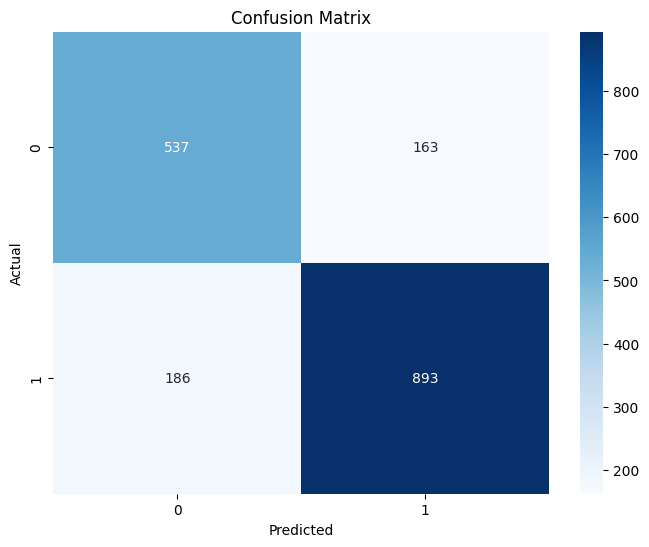

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       700
         1.0       0.85      0.83      0.84      1079

    accuracy                           0.80      1779
   macro avg       0.79      0.80      0.80      1779
weighted avg       0.81      0.80      0.80      1779



In [135]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

## Advanced with LIAR


Validation Set Accuracy: 0.4837558454344081

Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.55      0.37      0.44      4488
           1       0.45      0.62      0.52      3638

    accuracy                           0.48      8126
   macro avg       0.50      0.50      0.48      8126
weighted avg       0.50      0.48      0.48      8126



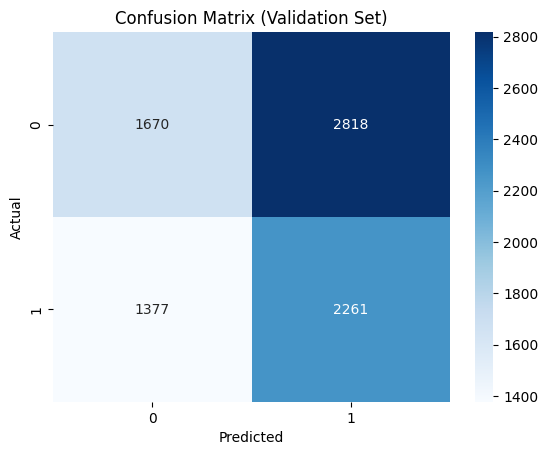

In [136]:
# Load dataset
liar_data = pd.read_csv("liar_dataset/liar_fr.csv")

# Define features and target
X_liar_val = liar_data['content']  # Text content
y_liar_val = liar_data[target_column]  

# Transform validation data using a pre-fitted vectorizer
liar_features = feature_extraction.transform(X_liar_val)  # No fit, just transform

# Predict using a pre-trained classifier


y_liar_val_pred = clf.predict(liar_features)

# Evaluation metrics
print("\nValidation Set Accuracy:", accuracy_score(y_liar_val, y_liar_val_pred))
print("\nClassification Report for Validation Set:\n", classification_report(y_liar_val, y_liar_val_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_liar_val, y_liar_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()